# Inverting image operations

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2)
plt.style.use('seaborn-whitegrid')

from scipy import sparse

## Import an image of a Social Security Number

In [2]:
from PIL import Image
img = Image.open('ssn.png')
xmat = (255 - np.asarray(img).max(axis=2))/255
print(xmat.shape)
print(xmat.min(),xmat.max())

(40, 100)
0.0 1.0


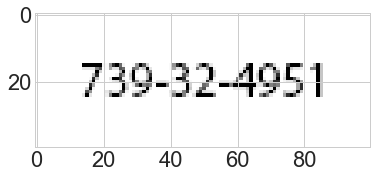

In [3]:
plt.imshow(xmat);

## "Vectorize" the image, creating the 1d array `x`

In [4]:
x = xmat.flatten()
x.shape

(4000,)

## Construct a "blur" matrix
More about this blur matrix on a later MP...

In [5]:
imat, jmat = np.meshgrid(np.arange(xmat.shape[0]), np.arange(xmat.shape[1]), indexing='ij')

ivec = np.atleast_2d(imat.flatten())
jvec = np.atleast_2d(jmat.flatten())

A = np.fmax(0, 1 - np.sqrt((ivec.T - ivec)**2 + (jvec.T - jvec)**2)/5)
A /= A.sum(axis=1)

## Compute b = A x

In [6]:
b = A @ x

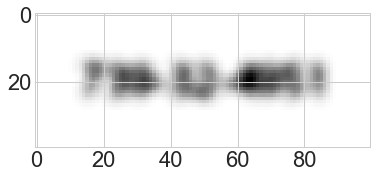

In [7]:
b2D=b.reshape(xmat.shape)
plt.imshow(b2D)

## Assume we have the blurred image, solve for the unblurred one

### Let's first get the LU factorization

In [9]:
import scipy.linalg as sla
P, L, U = sla.lu(A)

### What about "Solving"?

If $Ax = P L U x = b$, then there are two steps:
1. $y \leftarrow \text{solve}\,\, L y = P^Tb$
2. $x \leftarrow \text{solve}\,\, U x = y$

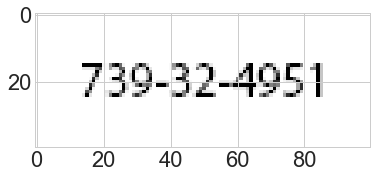

In [10]:
y = sla.solve_triangular(L, np.dot(P.T, b), lower=True)
x_solve = sla.solve_triangular(U, y)

plt.imshow(x_solve.reshape(xmat.shape))

### Why not just `np.linalg.solve`?

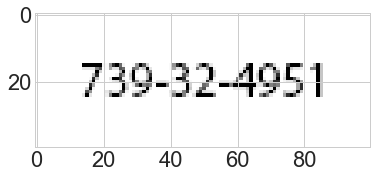

In [11]:
x_solve_2 = la.solve(A,b)
plt.imshow(x_solve_2.reshape(xmat.shape))

Suppose you have many social security numbers to un-blur. You should factorize your blur matrix only once and then perform several triangular solves.

Let's time:

1. solve including factorization
2. factorization
3. solve, given a factorization

In [12]:
%timeit sla.solve(A, b)

872 ms ± 5.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit P, L, U = sla.lu(A)

1 s ± 23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit sla.solve_triangular(U, y)

25.2 ms ± 316 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Let's take a look at the matrix format

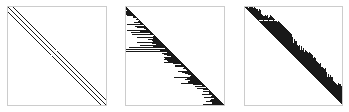

In [15]:
plt.figure()
plt.subplot(131)
plt.spy(A); plt.xticks([]); plt.yticks([]);

plt.subplot(132)
plt.spy(L); plt.xticks([]); plt.yticks([]);

plt.subplot(133)
plt.spy(U); plt.xticks([]); plt.yticks([]);

In [16]:
 A_csr = sparse.csr_matrix(A)

In [17]:
%timeit sparse.linalg.spsolve(A_csr,b)

380 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


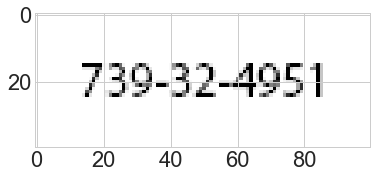

In [18]:
x_solve_3 = sparse.linalg.spsolve(A_csr,b)
plt.imshow(x_solve_3.reshape(xmat.shape))

# Now add some noise

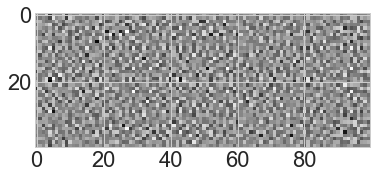

In [24]:
b_noisy = b + 1e-2 * np.random.rand(b.size)

y = sla.solve_triangular(L, np.dot(P.T, b_noisy), lower=True)
x_solve = sla.solve_triangular(U, y)

plt.imshow(x_solve.reshape(xmat.shape))
